## Coding exercises

In [ ]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np
import simpy
from matplotlib.axes import Axes
from matplotlib.figure import Figure

RNG = np.random.default_rng(seed=0)

All examples use SimPy to streamline simulations.

### 1. Simple closed queueing network

Implement a simulation for a closed queuing network with one CPU and one job in the loop.
The CPU processing times (in seconds) should be exponentially distributed with $\lambda_{S}=0.2$.
Run the simulation up until 10 seconds and print out what is happening in the system during state updates.

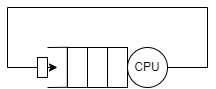

In [ ]:
class SimpleClosedNet:
    def __init__(self, lambda_s:float) -> None:
        self.env = simpy.Environment()
        self.beta_s = 1. / lambda_s
        self.cpu = simpy.Resource(self.env, capacity=1)

    def cpu_generator(self) -> Generator:
        job_iter = 1

        while True:
            with self.cpu.request() as request:
                print(f"Time {self.env.now:.4f}:\tjob iter {job_iter} waiting for CPU")
                yield request
                print(f"Time {self.env.now:.4f}:\tjob iter {job_iter} starts using CPU")
                yield self.env.timeout(RNG.exponential(scale=self.beta_s))
                print(f"Time {self.env.now:.4f}:\tjob iter {job_iter} finished using CPU")

            job_iter += 1

    def run(self, t: float) -> None:
        self.env.process(self.cpu_generator())
        self.env.run(until=t)

In [ ]:
simple_closed_net = SimpleClosedNet(0.2)
simple_closed_net.run(10)

### 2. Simple open queueing network

Implement a simulation for an open queuing network with one CPU.
The job interarrival and processing times should be exponentially distributed with $\lambda_{I}=0.6$ and $\lambda_{S}=0.2$, respectively.
Run the simulation up until 40 seconds and print out what is happening in the system during state updates.

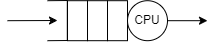

In [ ]:
class SimpleOpenNet:
    def __init__(self, lambda_i: float, lambda_s: float) -> None:
        self.env = simpy.Environment()
        self.beta_i = 1. / lambda_i
        self.beta_s = 1. / lambda_s
        self.cpu = simpy.Resource(self.env, capacity=1)

    def cpu_generator(self, job_id: int) -> Generator:
        with self.cpu.request() as request:
            print(f"Time {self.env.now:.4f}:\tjob id {job_id} arriving to CPU")
            yield request
            print(f"Time {self.env.now:.4f}:\tjob id {job_id} starts using CPU")
            yield self.env.timeout(RNG.exponential(scale=self.beta_s))
            print(f"Time {self.env.now:.4f}:\tjob {job_id} finished using CPU")

    def job_generator(self) -> Generator:
        job_id = 0

        while True:
            yield self.env.timeout(RNG.exponential(self.beta_i))
            self.env.process(self.cpu_generator(job_id))
            job_id += 1

    def run(self, t: float) -> None:
        self.env.process(self.job_generator())
        self.env.run(until=t)

In [ ]:
simple_open_net = SimpleOpenNet(0.6, 0.2)
simple_open_net.run(40)

### 3. (Closed) network throughput with successive queues & multiple jobs

Implement a simulation for a closed queuing network with one CPU followed by one disk and two jobs in the loop.
The CPU and disk processing times (in seconds) should be exponentially distributed with $\lambda_{S\_CPU}=0.2$ and $\lambda_{S\_DISK}=0.1$.
Run the simulation up until 40 seconds and print out what is happening in the system during state updates.

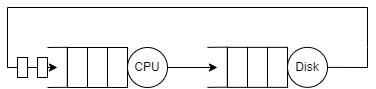

*Metric*:
After running the simulation once, rerun it 5 times for each of the following time durations, collecting the mean system throughput (in compelted jobs per second): 100, 1_000, and 10_000.
A completion entails any of the two jobs looping through the system once, starting and ending with arriving into the queue for CPU execution.
Create a barplot with the mean/min/max throughput for the three durations.
You may disable the prints for runs after the first one.

In [ ]:
class SuccessiveClosedNet:
    def __init__(self, lambda_s_cpu: float, lambda_s_disk: float, printing: bool) -> None:
        self.env = simpy.Environment()
        self.beta_s_cpu = 1. / lambda_s_cpu
        self.beta_s_disk = 1. / lambda_s_disk
        self.printing = printing
        self.cpu = simpy.Resource(self.env, capacity=1)
        self.disk = simpy.Resource(self.env, capacity=1)
        self.n_jobs = 0

    def print(self, *values: str) -> None:
        if self.printing:
            print(*values)

    def cpu_disk_generator(self, job_id: int) -> Generator:
        job_iter = 1

        while True:
            with self.cpu.request() as request:
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter} waiting for CPU")
                yield request
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter} starts using CPU")
                yield self.env.timeout(RNG.exponential(scale=self.beta_s_cpu))
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter} finished using CPU")

            with self.disk.request() as request:
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter} waiting for disk")
                yield request
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter} starts using disk")
                yield self.env.timeout(RNG.exponential(scale=self.beta_s_disk))
                self.print(
                    f"Time {self.env.now:.4f}:\tjob id {job_id} iter {job_iter}",
                    "finished using disk")

            job_iter += 1
            self.n_jobs += 1

    def run(self, t: float) -> None:
        self.env.process(self.cpu_disk_generator(0))
        self.env.process(self.cpu_disk_generator(1))
        self.env.run(t)

    def system_throughput(self) -> float:
        return self.n_jobs / self.env.now

In [ ]:
successive_lambda_s_cpu = 0.2
successive_lambda_s_disk = 0.1

successive_closed_net = SuccessiveClosedNet(successive_lambda_s_cpu, successive_lambda_s_disk, True)
successive_closed_net.run(40)

In [ ]:
def plot_system_throughput(sim_lengths: list[int], n_repetitions: int) -> Figure:
    throughputs = np.empty((len(sim_lengths), n_repetitions))

    for i, length in enumerate(sim_lengths):
        for j in range(n_repetitions):
            net = SuccessiveClosedNet(
                successive_lambda_s_cpu, successive_lambda_s_disk, False)
            net.run(length)
            throughputs[i][j] = net.system_throughput()

    ax: Axes
    fig, ax = plt.subplots()
    ax.set_xlabel("Simulation length")
    ax.set_ylabel("System throughput")
    sim_length_strs = [str(length) for length in sim_lengths]
    mean_throughputs = throughputs.mean(axis=-1)
    ax.bar(
        x=sim_length_strs,
        height=mean_throughputs)
    ax.errorbar(
        x=sim_length_strs, y=mean_throughputs,
        yerr=[
            mean_throughputs - throughputs.min(axis=-1),
            throughputs.max(axis=-1) - mean_throughputs],
        fmt='o', color='k')
    plt.close(fig)

    return fig

In [ ]:
plot_system_throughput([100, 1_000, 10_000], 5)

### 4. (Open) network response time with split queues

Implement a simulation for an open queuing network where each job passes through one of two CPUs with equal probability.
The job interarrival times should be exponentially distributed with $\lambda_{I}=0.6$.
Consider one fast CPU and one slow CPU having exponentially distributed processing times with $\lambda_{S\_fast}=1.0$ and $\lambda_{S\_slow}=0.4$, respectively.
Run the simulation up until 10 seconds and print out what is happening in the system during state updates.

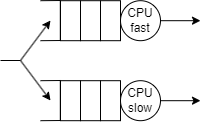

*Metric*:
After running the simulation once, rerun it 5 times for each of the following time durations, collecting the mean response time (in seconds): 100, 1_000, 10_000, and 20_000.
Create a barplot with the mean/min/max time for the three durations.
You may disable the prints for runs after the first one.

In [ ]:
class SplitOpenNet:
    def __init__(
            self, lambda_i: float,
            lambda_s_fast: float, lambda_s_slow: float,
            printing: bool) -> None:
        self.env = simpy.Environment()
        self.beta_i = 1. / lambda_i
        self.beta_s_fast = 1. / lambda_s_fast
        self.beta_s_slow = 1. / lambda_s_slow
        self.printing = printing
        self.cpu_fast = simpy.Resource(self.env, capacity=1)
        self.cpu_slow = simpy.Resource(self.env, capacity=1)
        self.n_jobs = 0
        self.response_time_acc = 0.

    def print(self, *values: str) -> None:
        if self.printing:
            print(*values)

    def cpu_generator(self, job_id: int) -> Generator:
        self.n_jobs += 1
        job_start_time = self.env.now
        speed = RNG.choice(["fast", "slow"])

        if speed == "fast":
            cpu = self.cpu_fast
            beta_s = self.beta_s_fast
        else:
            cpu = self.cpu_slow
            beta_s = self.beta_s_slow

        with cpu.request() as request:
            self.print(f"Time {self.env.now:.4f}:\tjob id {job_id} arriving to {speed} CPU")
            yield request
            self.print(f"Time {self.env.now:.4f}:\tjob id {job_id} starts using {speed} CPU")
            yield self.env.timeout(RNG.exponential(scale=beta_s))
            self.print(f"Time {self.env.now:.4f}:\tjob {job_id} finished using {speed} CPU")

        self.response_time_acc += self.env.now - job_start_time

    def job_generator(self) -> Generator:
        while True:
            yield self.env.timeout(RNG.exponential(self.beta_i))
            self.env.process(self.cpu_generator(self.n_jobs))

    def run(self, t: float) -> None:
        self.env.process(self.job_generator())
        self.env.run(until=t)

    def response_time(self) -> float:
        return self.response_time_acc / self.n_jobs

In [ ]:
split_lambda_i = 0.6
split_lambda_s_fast = 1.0
split_lambda_s_slow = 0.4

split_open_net = SplitOpenNet(split_lambda_i, split_lambda_s_fast, split_lambda_s_slow, True)
split_open_net.run(10)

In [ ]:
def plot_response_time(sim_lengths: list[int], n_repetitions: int) -> Figure:
    times = np.empty((len(sim_lengths), n_repetitions))

    for i, length in enumerate(sim_lengths):
        for j in range(n_repetitions):
            net = SplitOpenNet(
                split_lambda_i, split_lambda_s_fast, split_lambda_s_slow, False)
            net.run(length)
            times[i][j] = net.response_time()

    ax: Axes
    fig, ax = plt.subplots()
    ax.set_xlabel("Simulation length")
    ax.set_ylabel("Response time")
    sim_length_strs = [str(length) for length in sim_lengths]
    mean_times = times.mean(axis=-1)
    ax.bar(
        x=sim_length_strs,
        height=mean_times)
    ax.errorbar(
        x=sim_length_strs, y=mean_times,
        yerr=[
            mean_times - times.min(axis=-1),
            times.max(axis=-1) - mean_times],
        fmt='o', color='k')
    plt.close(fig)

    return fig

In [ ]:
plot_response_time([100, 1_000, 10_000, 20_000], 5)

## Book exercises

### Chapter 14

Exercises 14.1, 14.2, 14.3